# Graph File Pre-Processing

In [ ]:
import numpy as np
import pandas as pd
import awkward as ak

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
import uproot
import torch

from tqdm import tqdm
import timeit
import os

import dill

# For building k-NN and adjacency
from scipy.spatial import cKDTree
import scipy.sparse as sp
import dgl
import pickle
import networkx as nx


In [ ]:
import numpy as np
import pandas as pd
import awkward as ak

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
import uproot
import torch

from tqdm import tqdm
import timeit
import os

import dill

# For building k-NN and adjacency
from scipy.spatial import cKDTree
import scipy.sparse as sp
import dgl
import pickle


# ------------------------------------------------------------------
# FUNCTIONS
# ------------------------------------------------------------------

# Take ROOT file and convert to an awkward array
def fileToAwk(path):
    file = uproot.open(path)
    tree = file['tree']
    awk = tree.arrays(tree.keys())
    return awk

# Features used to train the model
input_features = [
    "part_px", "part_py", "part_pz", "part_energy",
    "part_deta", "part_dphi", "part_d0val", "part_d0err",
    "part_dzval", "part_dzerr", "part_isChargedHadron", "part_isNeutralHadron",
    "part_isPhoton", "part_isElectron", "part_isMuon"
]

# Take AWK dict and convert to a point cloud
def awkToPointCloud(awkDict, input_features):
    featureVector = []
    for jet in tqdm(range(len(awkDict)), total=len(awkDict)):
        currJet = awkDict[jet][input_features]
        try:
            pT = np.sqrt(ak.to_numpy(currJet['part_px']) ** 2 + ak.to_numpy(currJet['part_py']) ** 2)
            # Create numpy array to represent the 4-momenta of all particles in a jet
            currJet = np.column_stack((
                ak.to_numpy(currJet['part_px']),
                ak.to_numpy(currJet['part_py']),
                ak.to_numpy(currJet['part_pz']),
                ak.to_numpy(currJet['part_energy']),
                pT,
                ak.to_numpy(currJet['part_deta']),
                ak.to_numpy(currJet['part_dphi']),
                ak.to_numpy(currJet["part_d0val"]),
                ak.to_numpy(currJet["part_d0err"]),
                ak.to_numpy(currJet["part_dzval"]),
                ak.to_numpy(currJet["part_dzerr"]),
                ak.to_numpy(currJet["part_isChargedHadron"]),
                ak.to_numpy(currJet["part_isNeutralHadron"]),
                ak.to_numpy(currJet["part_isPhoton"]),
                ak.to_numpy(currJet["part_isElectron"]),
                ak.to_numpy(currJet["part_isMuon"])
            ))
            featureVector.append(currJet)
        except Exception as e:
            print(f"Error processing jet {jet}: {e}")
            featureVector.append(np.empty((0, len(input_features) + 1)))  # Add an empty array for failed jets
    return featureVector  # Return a list of arrays instead of a single numpy array

# Build a KNN graph from a point cloud
def buildKNNGraph(points, k):
    tree = cKDTree(points)
    dists, indices = tree.query(points, k+1)  # +1 to exclude self

    num_points = len(points)
    adj_matrix = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in indices[i, 1:]:  # exclude self
            adj_matrix[i, j] = 1
            adj_matrix[j, i] = 1
    return adj_matrix

# Convert adjacency matrix to a DGL graph
def adjacencyToDGL(adj_matrix):
    adj_matrix = sp.coo_matrix(adj_matrix)
    g_dgl = dgl.from_scipy(adj_matrix)
    return g_dgl

# Wrap the functionality of fileToAwk and awkToPointCloud into a single function
def fileToPointCloudArray(jetType, input_features):
    # filepath = f'/Volumes/Yash SSD/JetClass/JetRoots/{jetType}_000.root'  # original ROOT file
    filepath = f'./data/JetClass/JetRoots/JetClass_example_100k.root'  # original ROOT file
    savepath = f'./data/JetClass/PointClouds/{jetType}.npy'   # save file
    awk = fileToAwk(filepath)
    nparr = awkToPointCloud(awk, input_features)
    return nparr

# Combine all steps: read file → build adjacency → build DGL graph → optionally save
def fileToGraph(jetType, k=3, save=True):
    print(f'Starting processing on {jetType} jets')
    pointCloudArr = fileToPointCloudArray(jetType, input_features)
    saveFilePath = f'./data/Multi Level Jet Tagging/{jetType}.pkl'

    savedGraphs = []
    for idx, pointCloud in tqdm(enumerate(pointCloudArr), leave=False, total=len(pointCloudArr)):
        try:
            adj_matrix = buildKNNGraph(pointCloud, k)
            graph = adjacencyToDGL(adj_matrix)
            graph.ndata['feat'] = torch.tensor(pointCloud, dtype=torch.float32)
            savedGraphs.append(graph)

            # Cleanup
            del adj_matrix, graph
        except Exception as e:
            print(e)

    if save:
        with open(saveFilePath, 'wb') as f:
            pickle.dump(savedGraphs, f, protocol=pickle.HIGHEST_PROTOCOL)

        del pointCloudArr, savedGraphs

    print(f'Graphs for {jetType} processing complete!')
    return savedGraphs

def groupToGraph(jetTypeList, groupName):
    allGraphs = []
    for jetType in jetTypeList:
        allGraphs += fileToGraph(jetType, save=False)

    saveFilePath = f'./data/Multi Level Jet Tagging/{groupName}.pkl'
    with open(saveFilePath, 'wb') as f:
        pickle.dump(allGraphs, f, protocol=pickle.HIGHEST_PROTOCOL)
    return allGraphs

# ------------------------------------------------------------------
# MAIN EXECUTION (example usage)
# ------------------------------------------------------------------

# Example lists of jet types
Higgs = ['HToBB', 'HToCC', 'HToGG', 'HToWW2Q1L', 'HToWW4Q']
Vector = ['WToQQ', 'ZToQQ']
Top = ['TTBar', 'TTBarLep']
QCD = ['ZJetsToNuNu']
Emitter = ['Emitter-Vector', 'Emitter-Top', 'Emitter-Higgs', 'Emitter-QCD']
allJets = Higgs + Vector + Top + QCD

# If you want to process all jets, you could uncomment:
# for jetType in allJets:
#     fileToGraph(jetType)

# Example: build a group of Higgs graphs
allGraphs = groupToGraph(Higgs, "Emitter-Higgs")

# Save them
with open(f'./data/Multi Level Jet Tagging/Emitter-Higgs.pkl', 'wb') as f:
    pickle.dump(allGraphs, f)

print("DONE")


Starting processing on HToBB jets


 31%|███▏      | 31322/100000 [00:10<00:21, 3149.13it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▌      | 35027/100000 [00:11<00:19, 3370.60it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 57003/100000 [00:18<00:12, 3371.41it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for HToBB processing complete!
Starting processing on HToCC jets


 31%|███       | 31113/100000 [00:10<00:21, 3144.09it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34839/100000 [00:11<00:19, 3356.54it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 57035/100000 [00:18<00:12, 3435.71it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for HToCC processing complete!
Starting processing on HToGG jets


 31%|███       | 31164/100000 [00:21<00:21, 3130.60it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34885/100000 [00:22<00:19, 3367.94it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 57065/100000 [00:29<00:12, 3361.26it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for HToGG processing complete!
Starting processing on HToWW2Q1L jets


 31%|███       | 31160/100000 [00:12<00:22, 3058.31it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34847/100000 [00:13<00:20, 3184.97it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 56814/100000 [00:20<00:12, 3386.75it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for HToWW2Q1L processing complete!
Starting processing on HToWW4Q jets


 31%|███▏      | 31296/100000 [00:10<00:21, 3172.40it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34974/100000 [00:11<00:19, 3359.06it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 56870/100000 [00:19<00:12, 3390.00it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for HToWW4Q processing complete!
DONE


File loaded successfully! Total number of graphs: 499985
First 10 Graphs Info:
{'Graph Index': 0, 'Num Nodes': 38, 'Num Edges': 154, 'Node Feature Shape': torch.Size([38, 16])}
{'Graph Index': 1, 'Num Nodes': 30, 'Num Edges': 118, 'Node Feature Shape': torch.Size([30, 16])}
{'Graph Index': 2, 'Num Nodes': 39, 'Num Edges': 158, 'Node Feature Shape': torch.Size([39, 16])}
{'Graph Index': 3, 'Num Nodes': 32, 'Num Edges': 126, 'Node Feature Shape': torch.Size([32, 16])}
{'Graph Index': 4, 'Num Nodes': 45, 'Num Edges': 186, 'Node Feature Shape': torch.Size([45, 16])}
{'Graph Index': 5, 'Num Nodes': 42, 'Num Edges': 178, 'Node Feature Shape': torch.Size([42, 16])}
{'Graph Index': 6, 'Num Nodes': 41, 'Num Edges': 166, 'Node Feature Shape': torch.Size([41, 16])}
{'Graph Index': 7, 'Num Nodes': 49, 'Num Edges': 206, 'Node Feature Shape': torch.Size([49, 16])}
{'Graph Index': 8, 'Num Nodes': 49, 'Num Edges': 194, 'Node Feature Shape': torch.Size([49, 16])}
{'Graph Index': 9, 'Num Nodes': 24, 'Nu

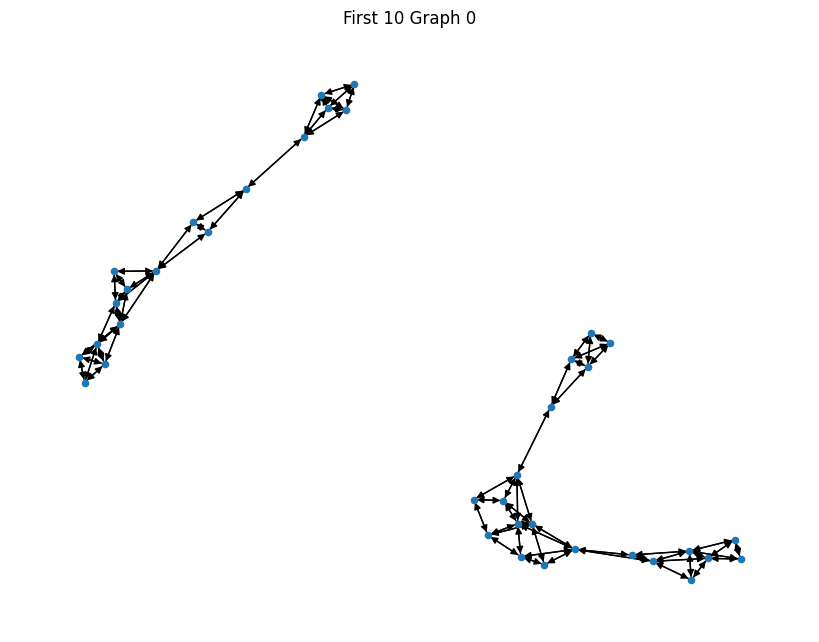

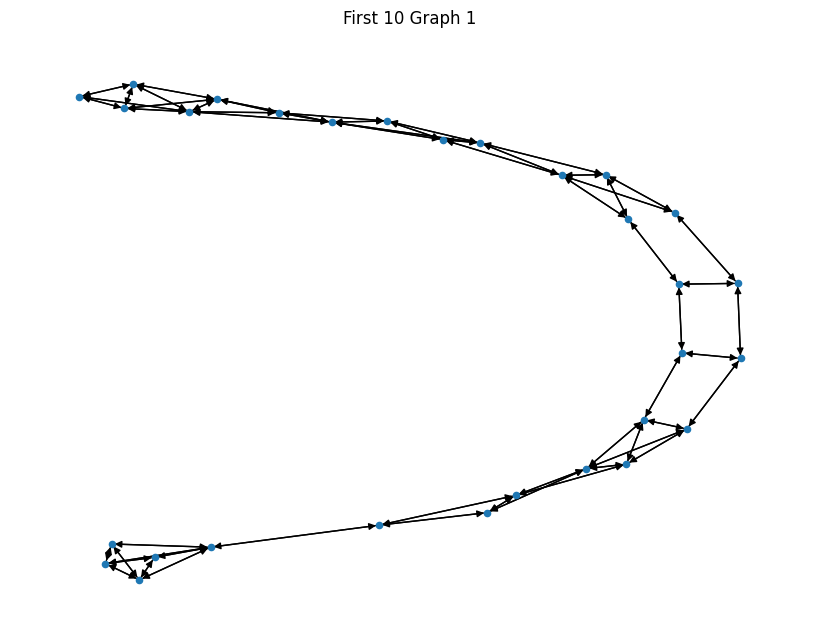

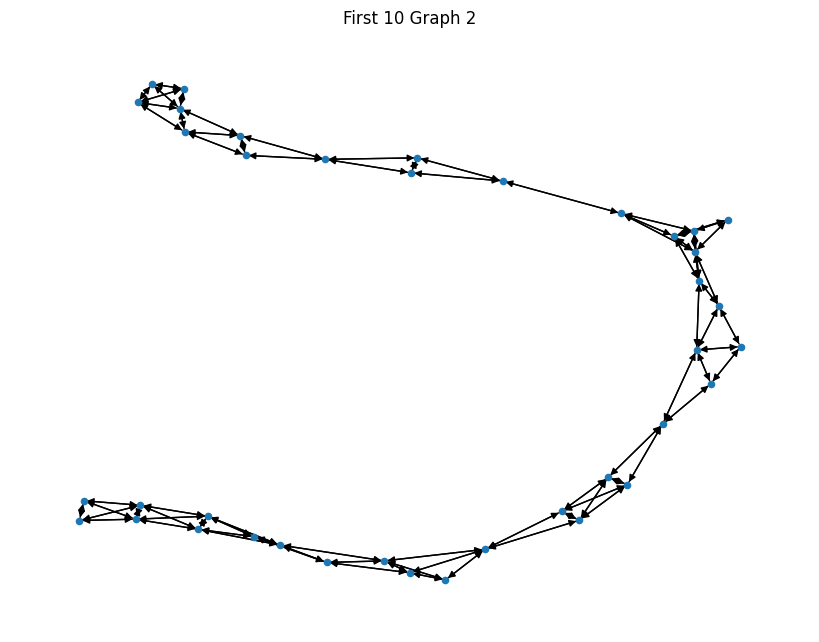

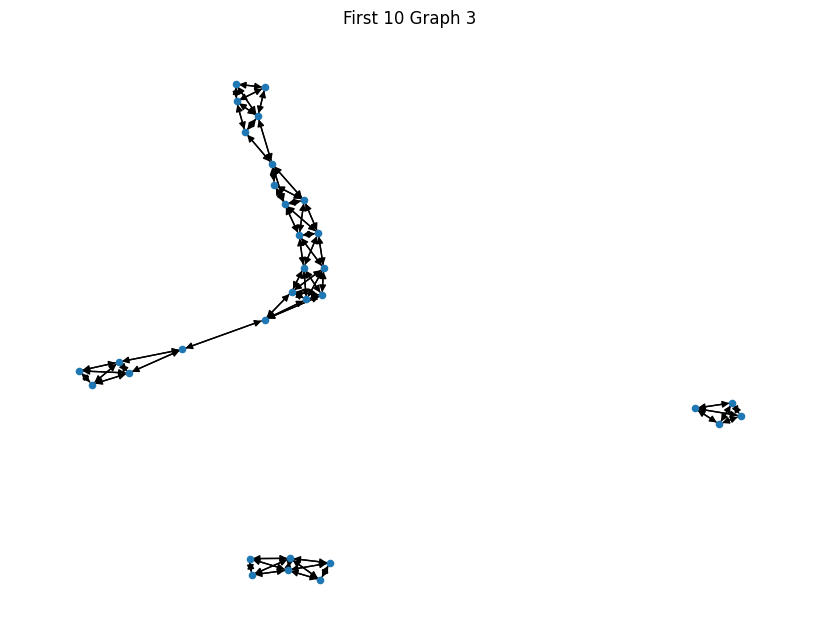

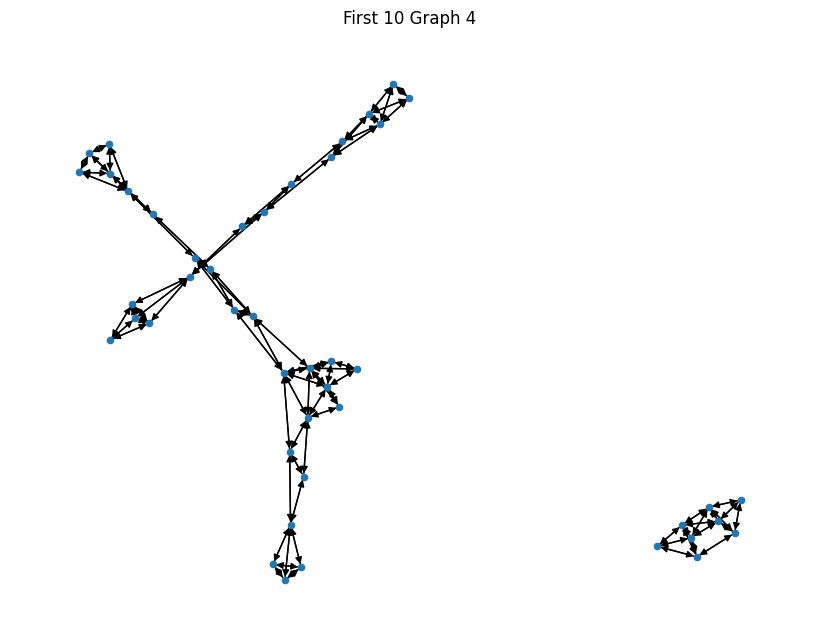

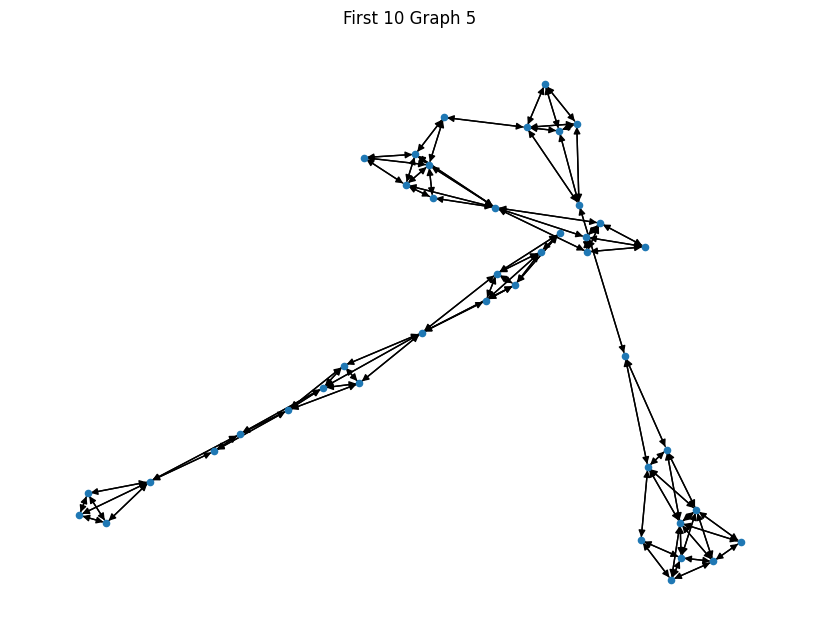

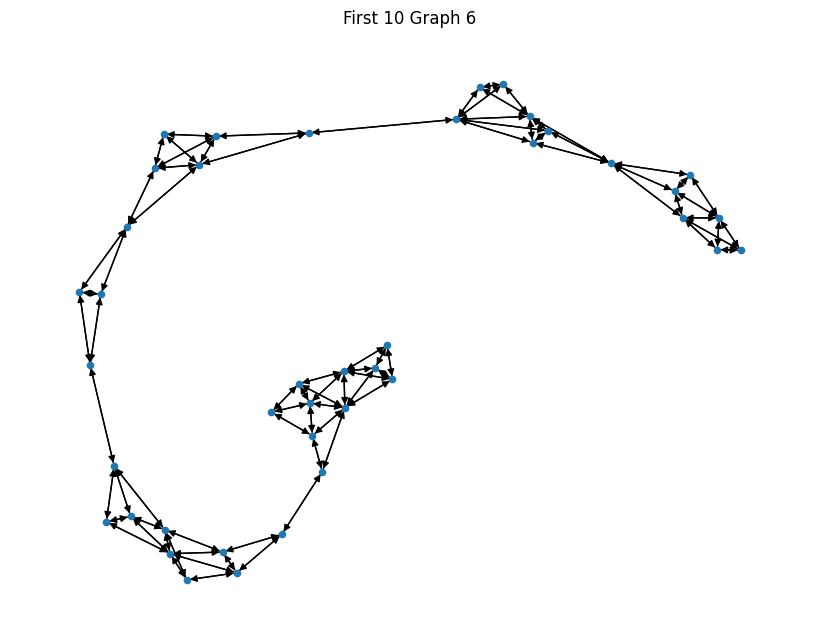

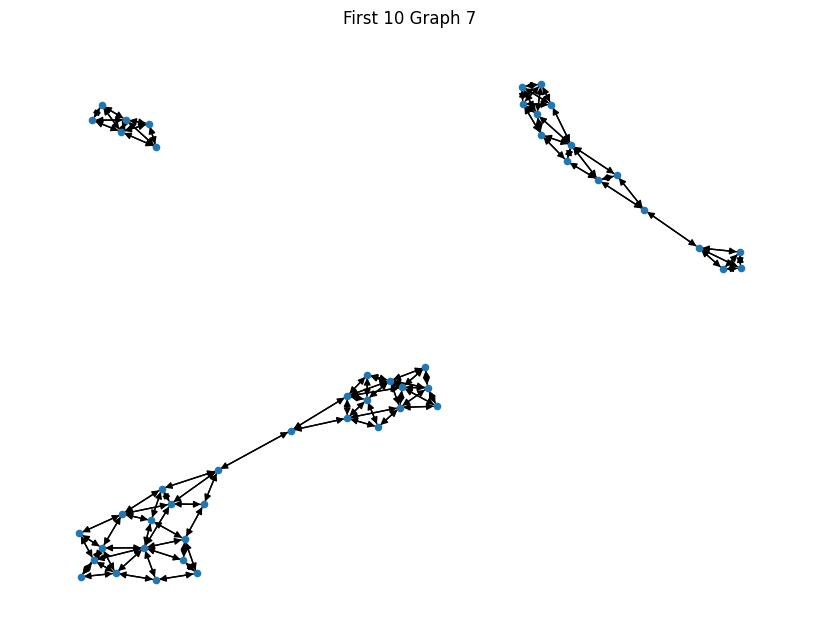

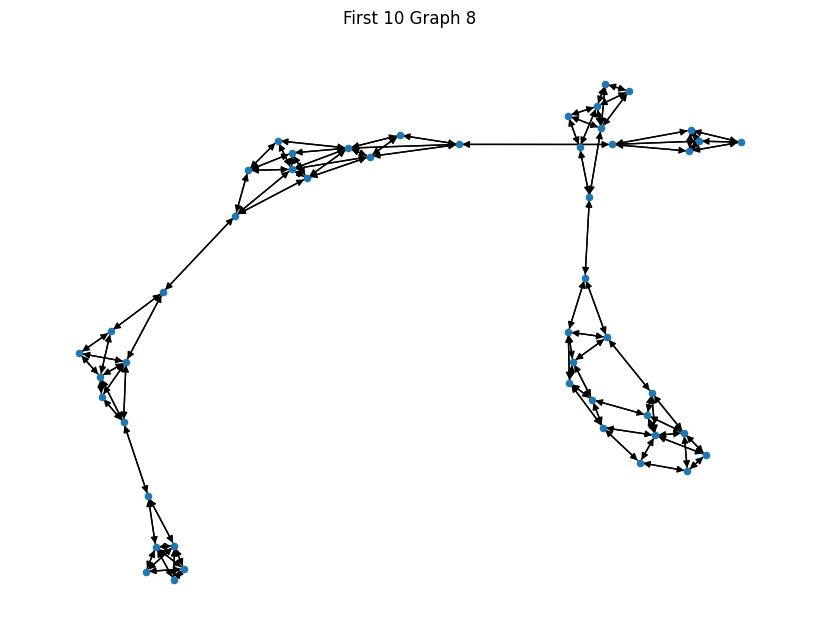

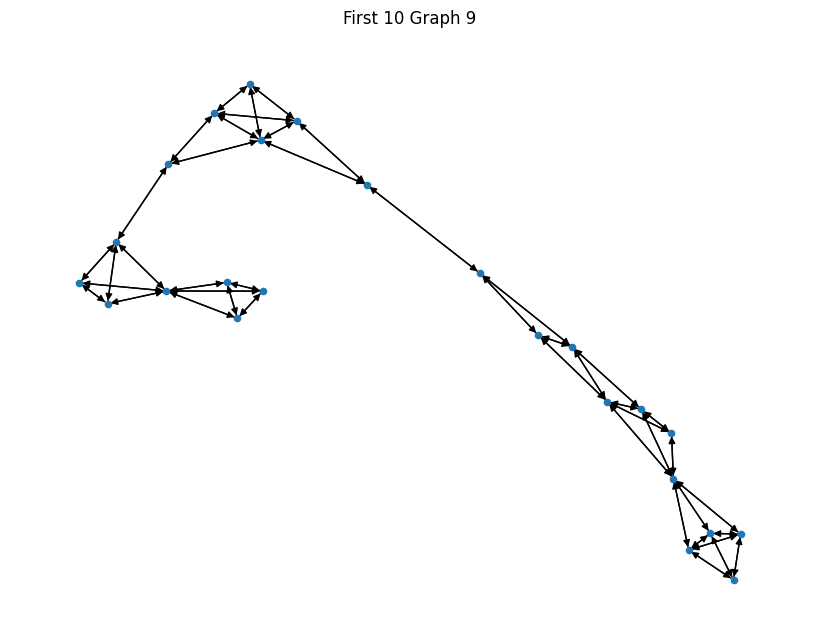

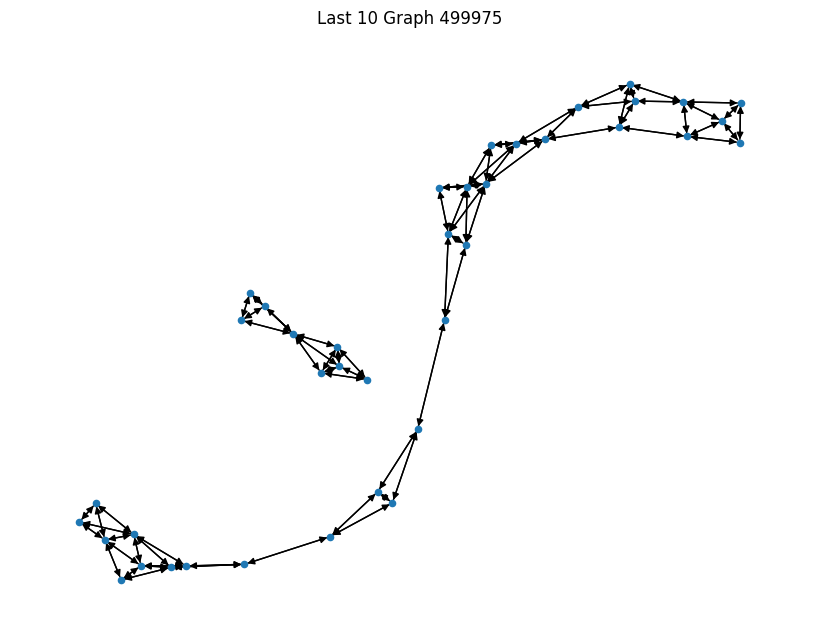

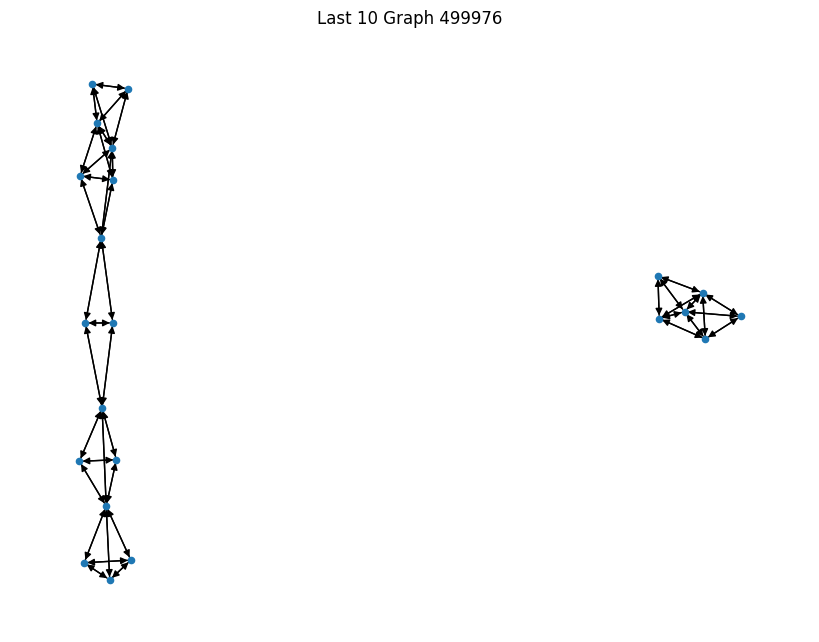

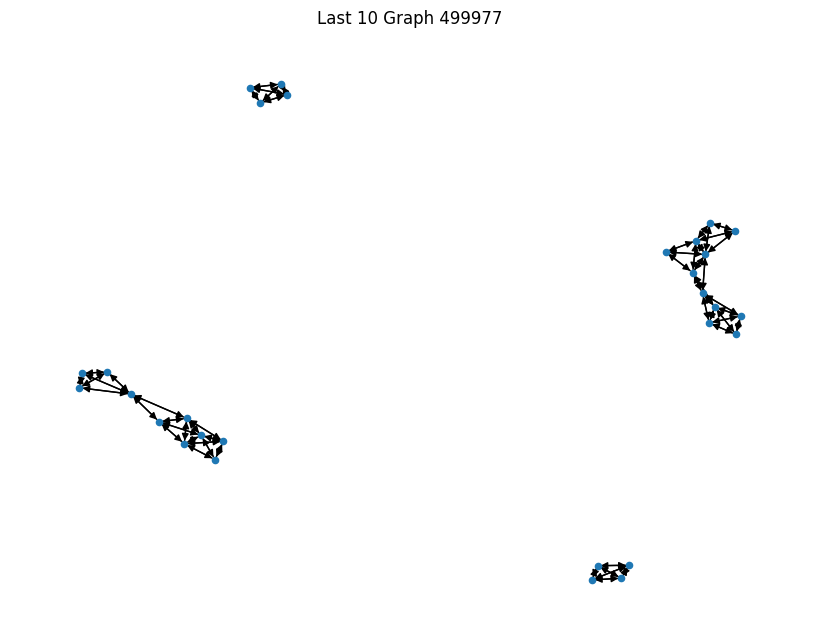

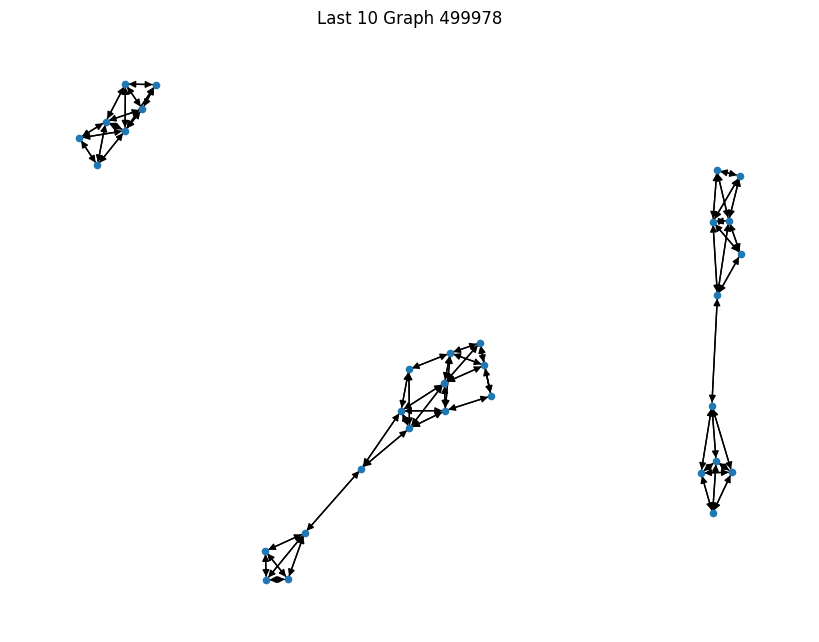

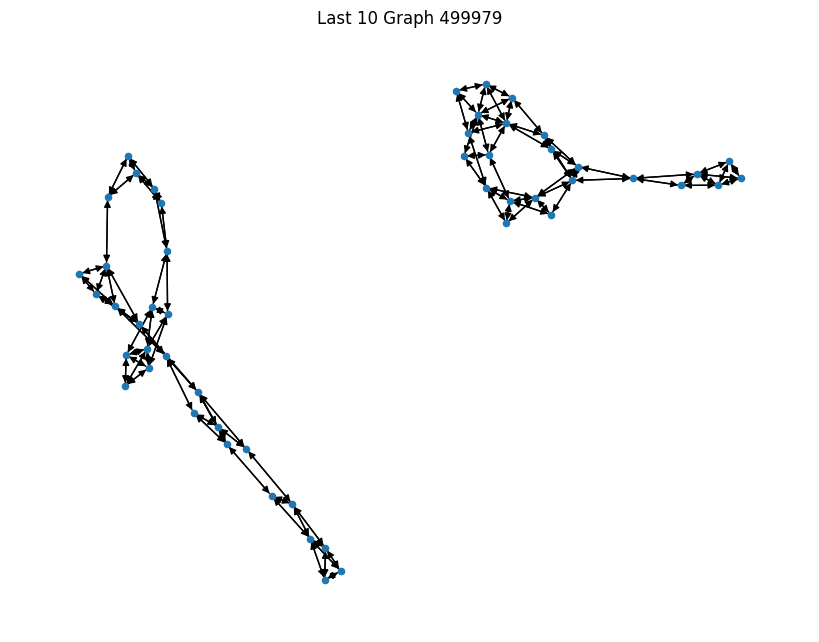

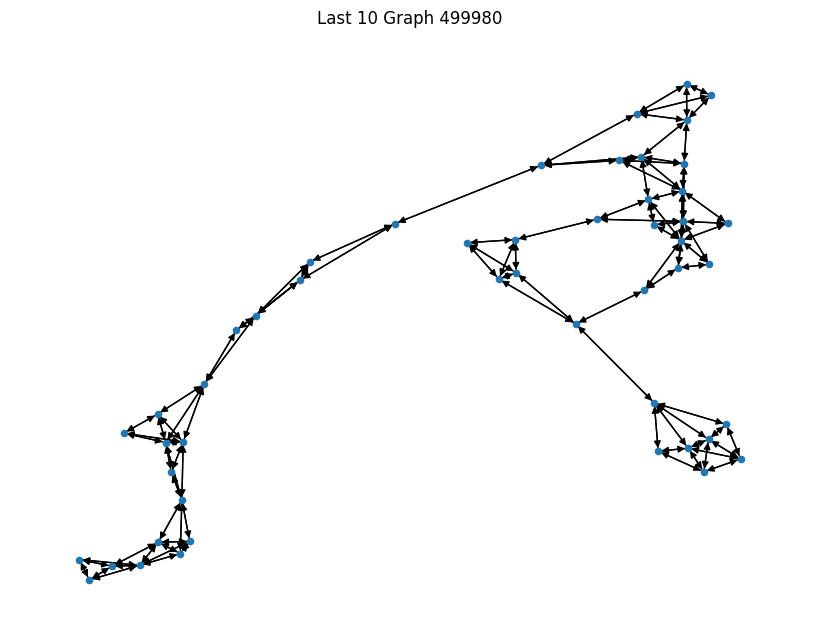

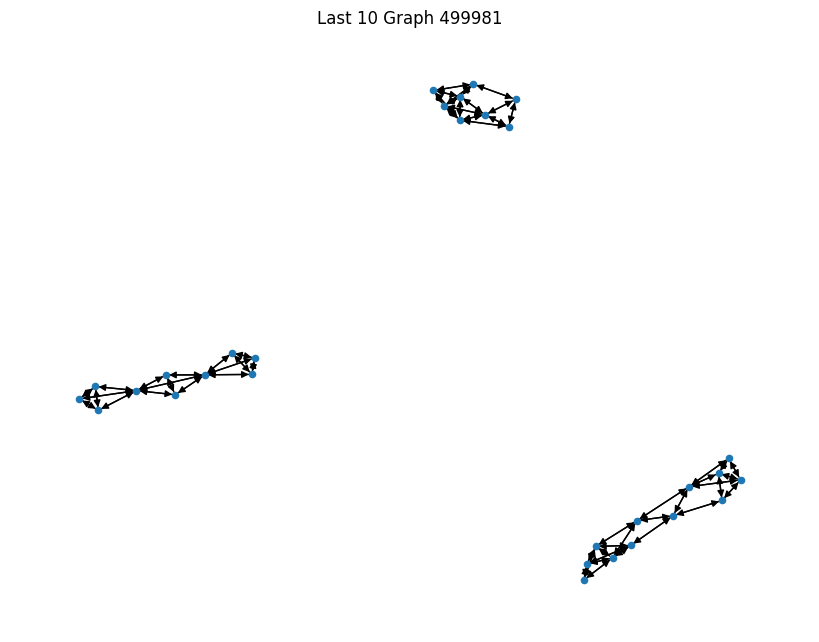

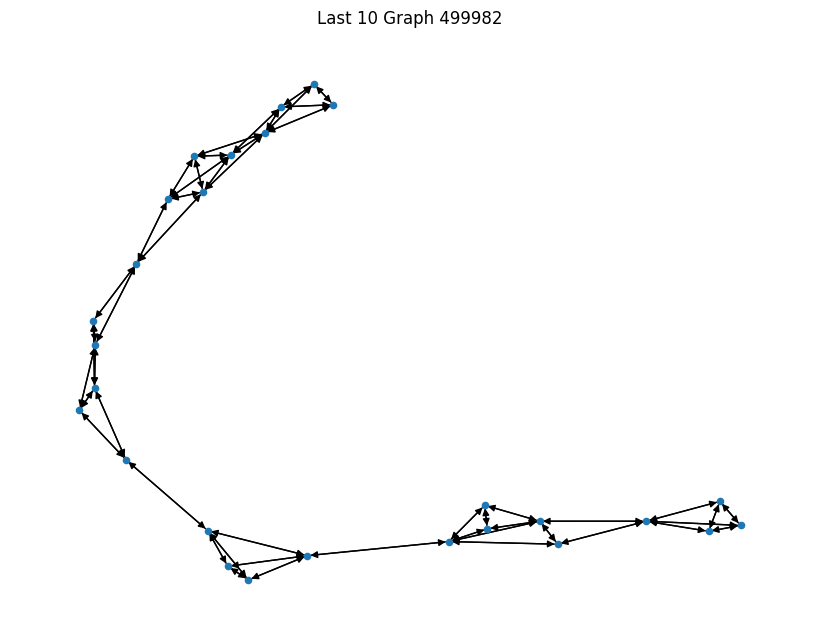

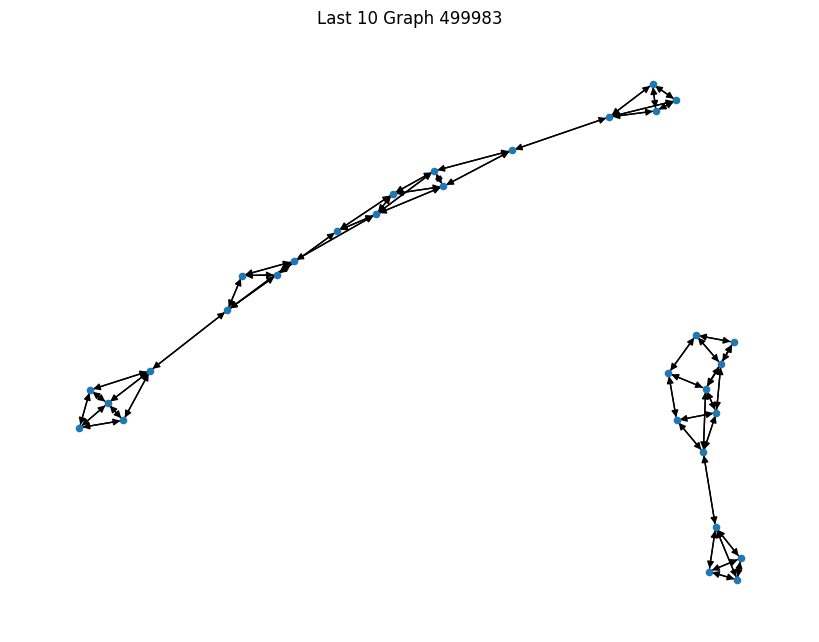

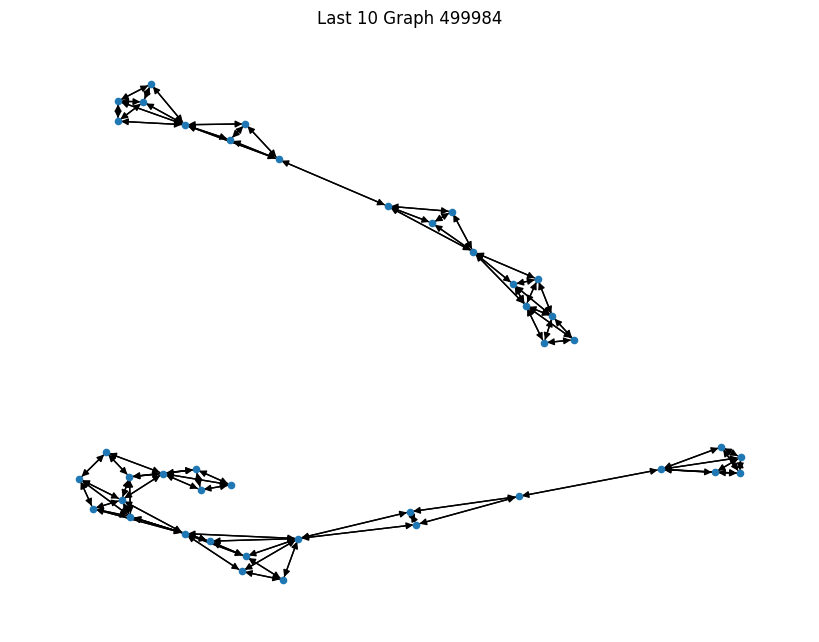

In [ ]:
import networkx as nx

# Load the saved .pkl file
file_path = './data/Multi Level Jet Tagging/Emitter-Higgs.pkl'
try:
    with open(file_path, 'rb') as f:
        graphs = pickle.load(f)
    print(f"File loaded successfully! Total number of graphs: {len(graphs)}")
except Exception as e:
    print(f"Failed to load the file: {e}")

# Helper function to display graph info
def get_graph_info(graphs, indices):
    info_list = []
    for i in indices:
        g = graphs[i]
        info = {
            "Graph Index": i,
            "Num Nodes": g.num_nodes(),
            "Num Edges": g.num_edges(),
            "Node Feature Shape": g.ndata['feat'].shape if 'feat' in g.ndata else None
        }
        info_list.append(info)
    return info_list

# Get the info for the first and last 10 graphs
first_10_indices = list(range(min(10, len(graphs))))
last_10_indices = list(range(max(0, len(graphs) - 10), len(graphs)))
first_10_info = get_graph_info(graphs, first_10_indices)
last_10_info = get_graph_info(graphs, last_10_indices)

# Display graph info
print("First 10 Graphs Info:")
for info in first_10_info:
    print(info)

print("\nLast 10 Graphs Info:")
for info in last_10_info:
    print(info)

# Visualization of first and last 10 graphs
def visualize_graphs(graphs, indices, title_prefix):
    for idx in indices:
        g = graphs[idx]
        nx_graph = g.to_networkx()
        plt.figure(figsize=(8, 6))
        nx.draw(nx_graph, node_size=20)
        plt.title(f"{title_prefix} Graph {idx}")
        plt.show()

# Visualize the first 10 graphs
visualize_graphs(graphs, first_10_indices, "First 10")

# Visualize the last 10 graphs
visualize_graphs(graphs, last_10_indices, "Last 10")


File loaded successfully! Total number of graphs: 499985


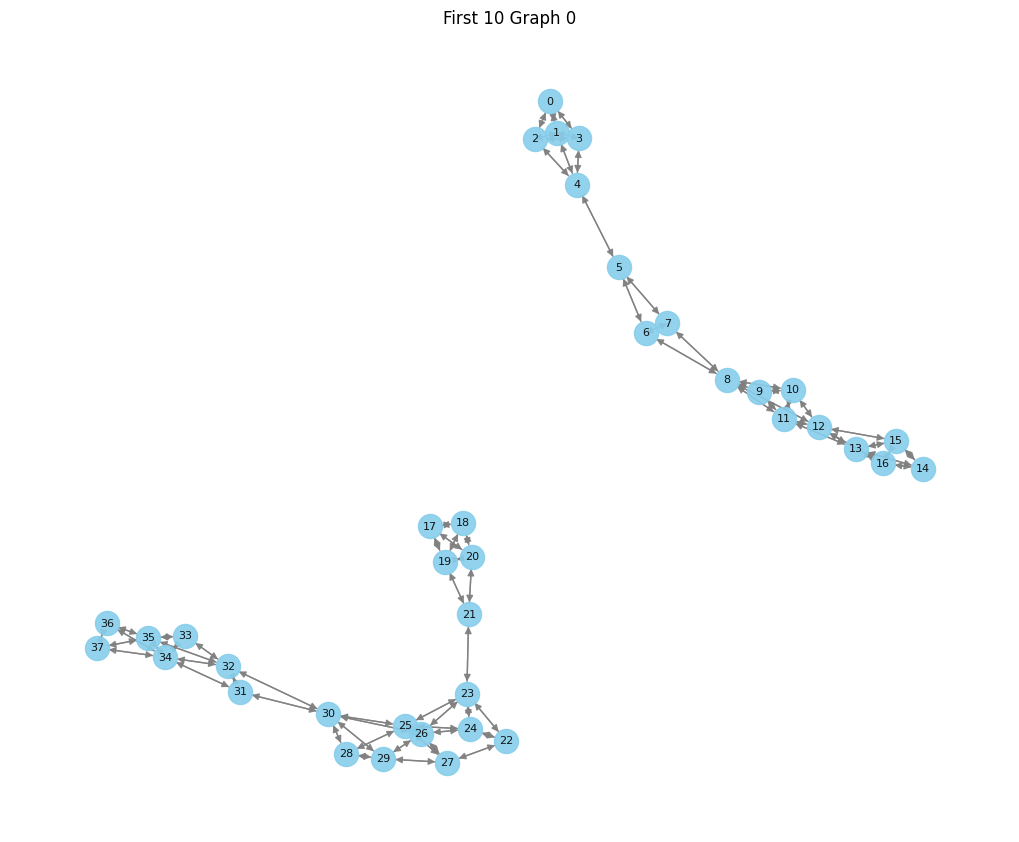

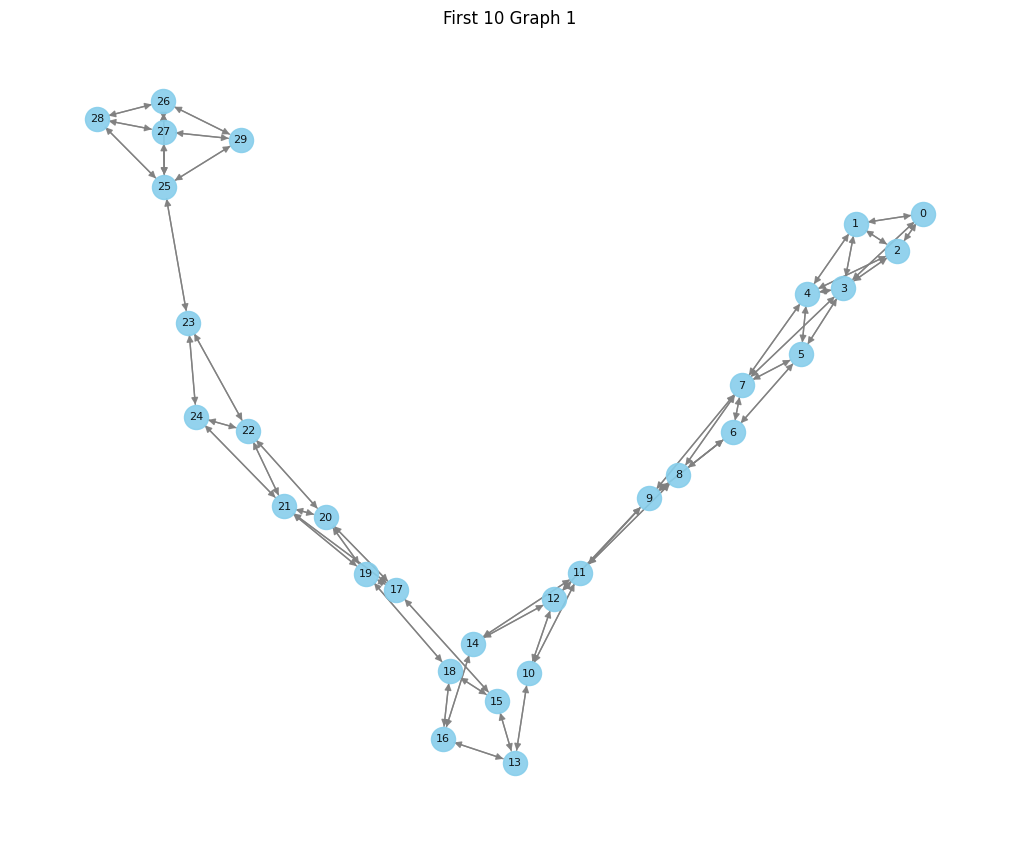

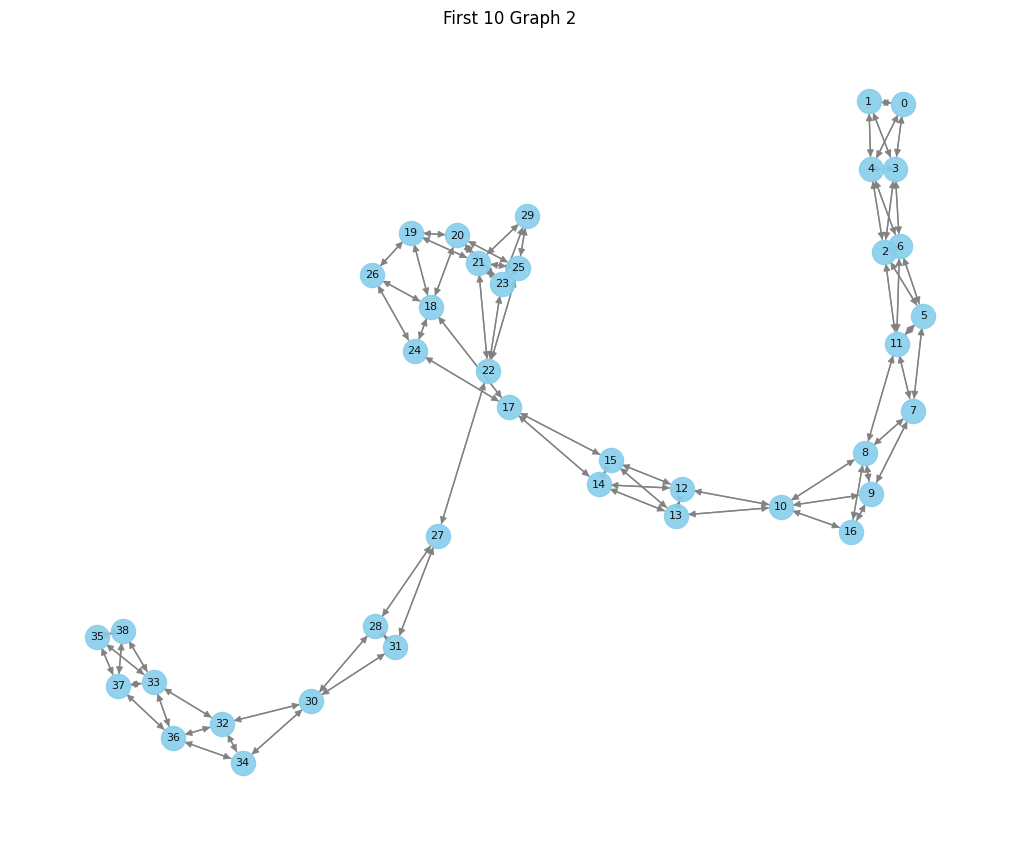

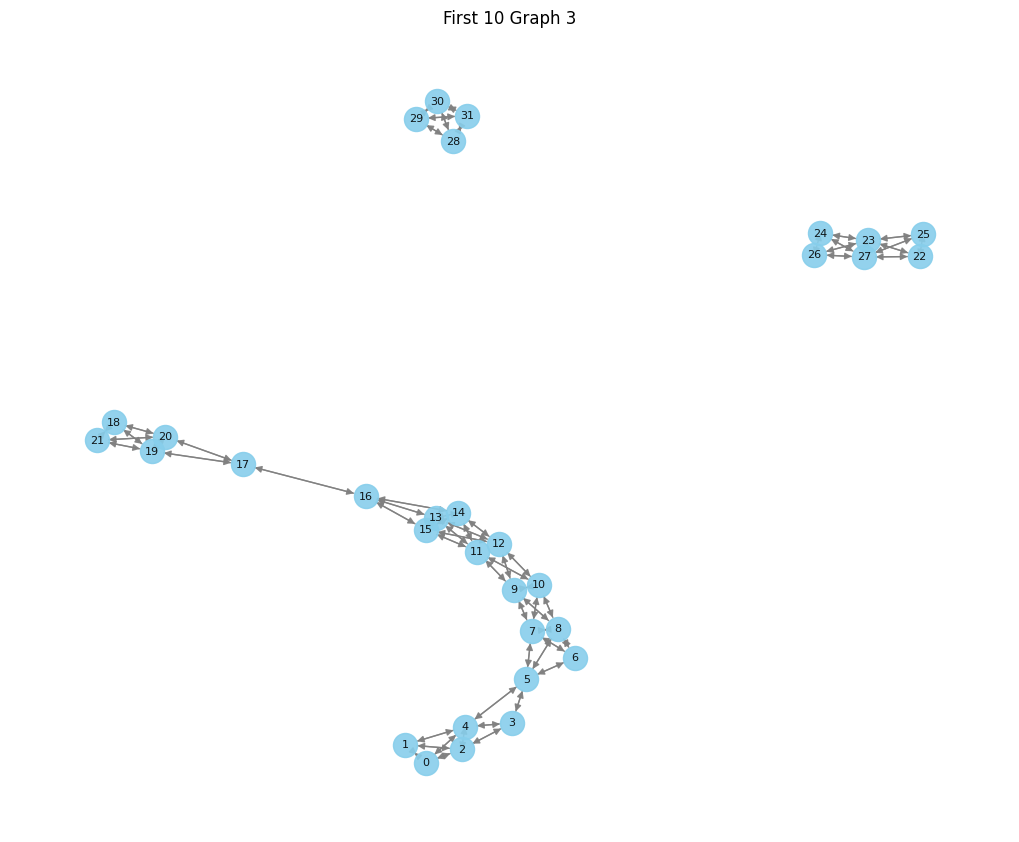

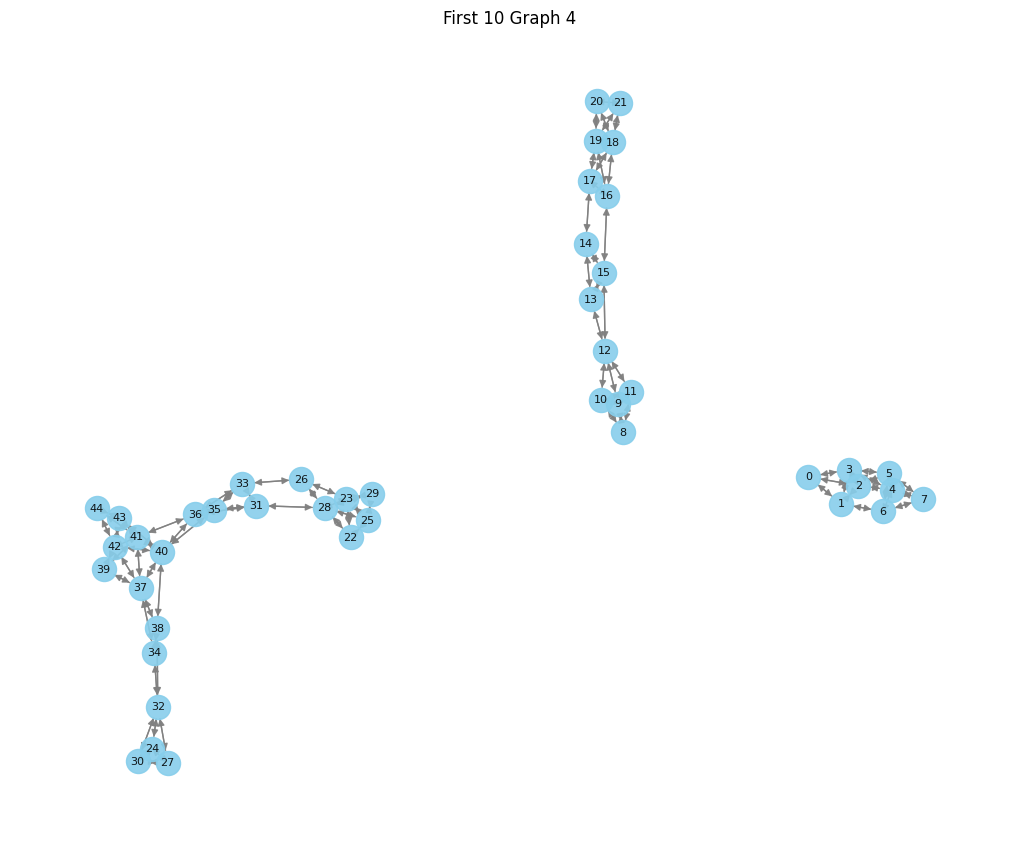

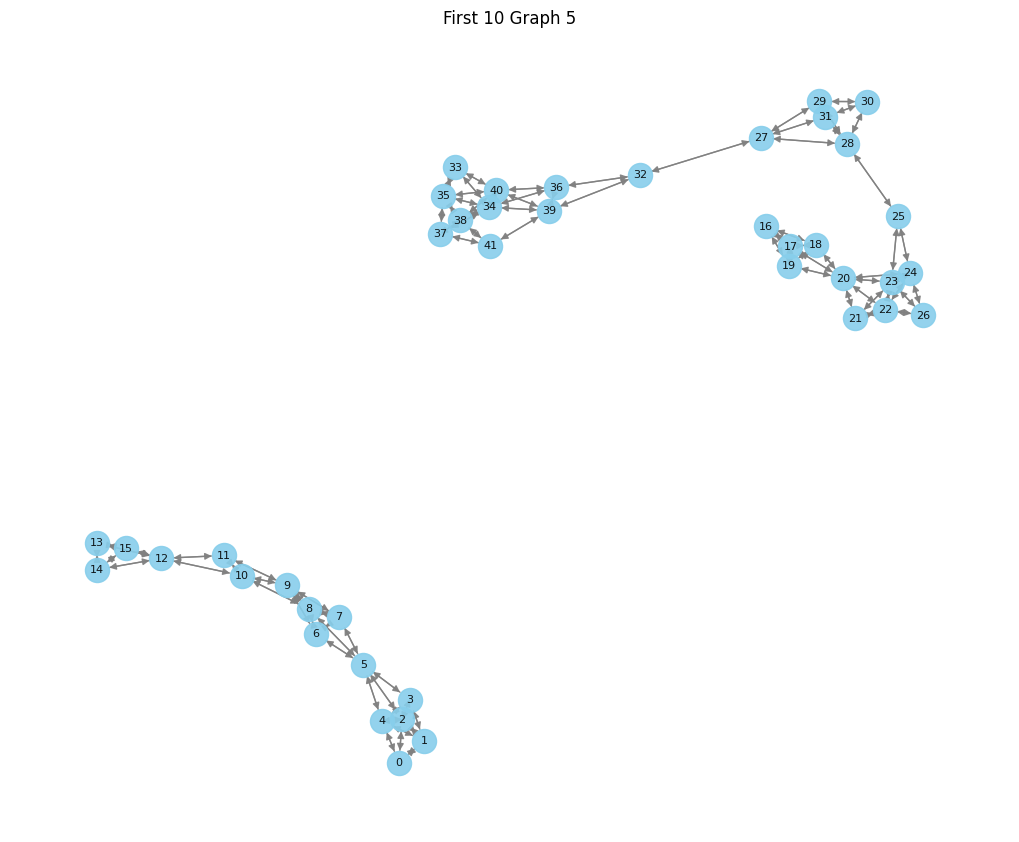

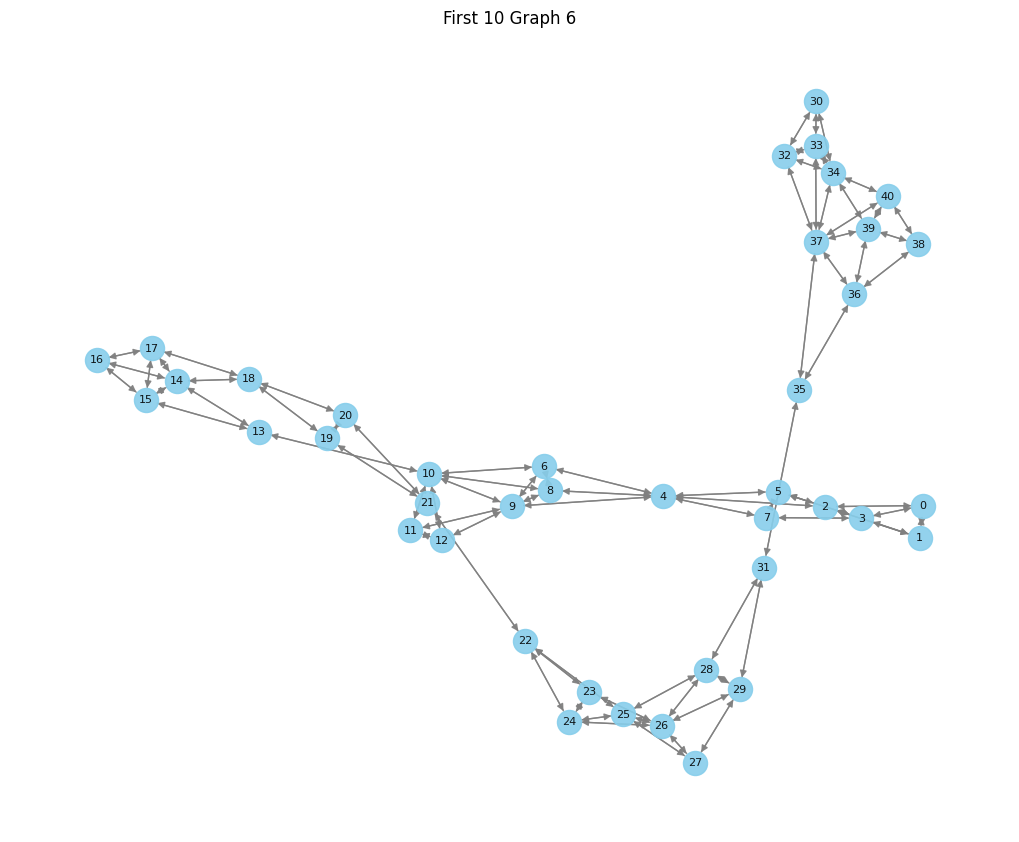

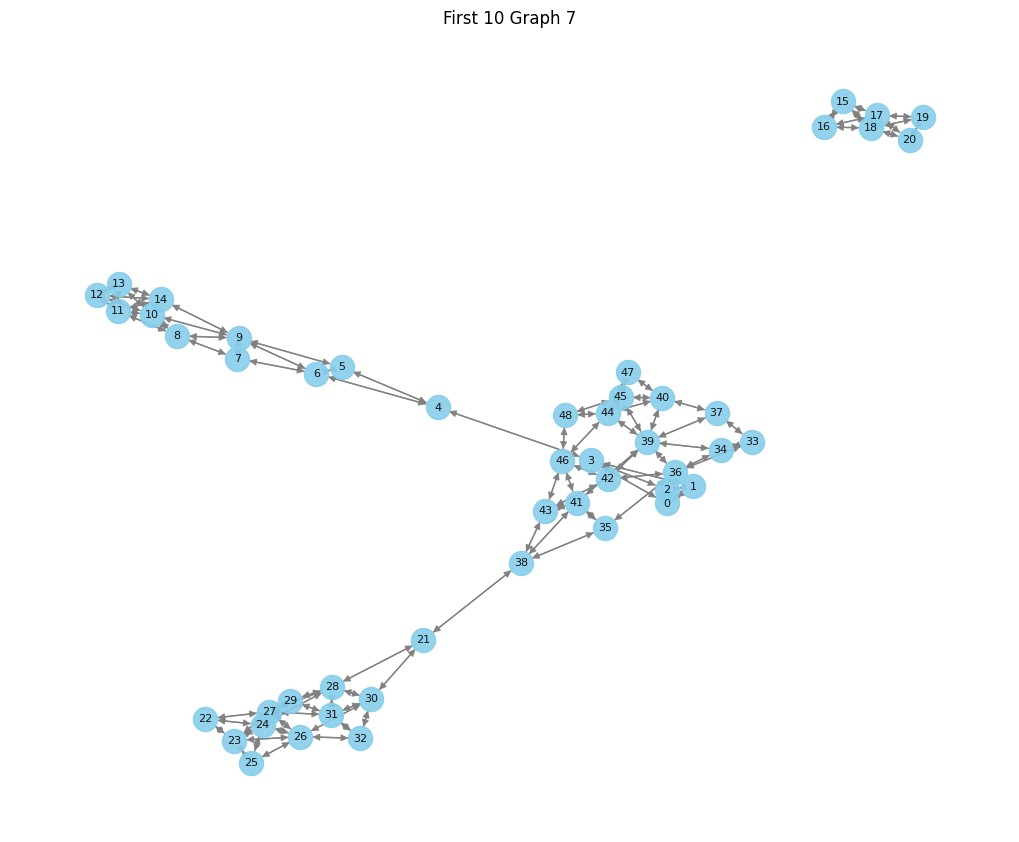

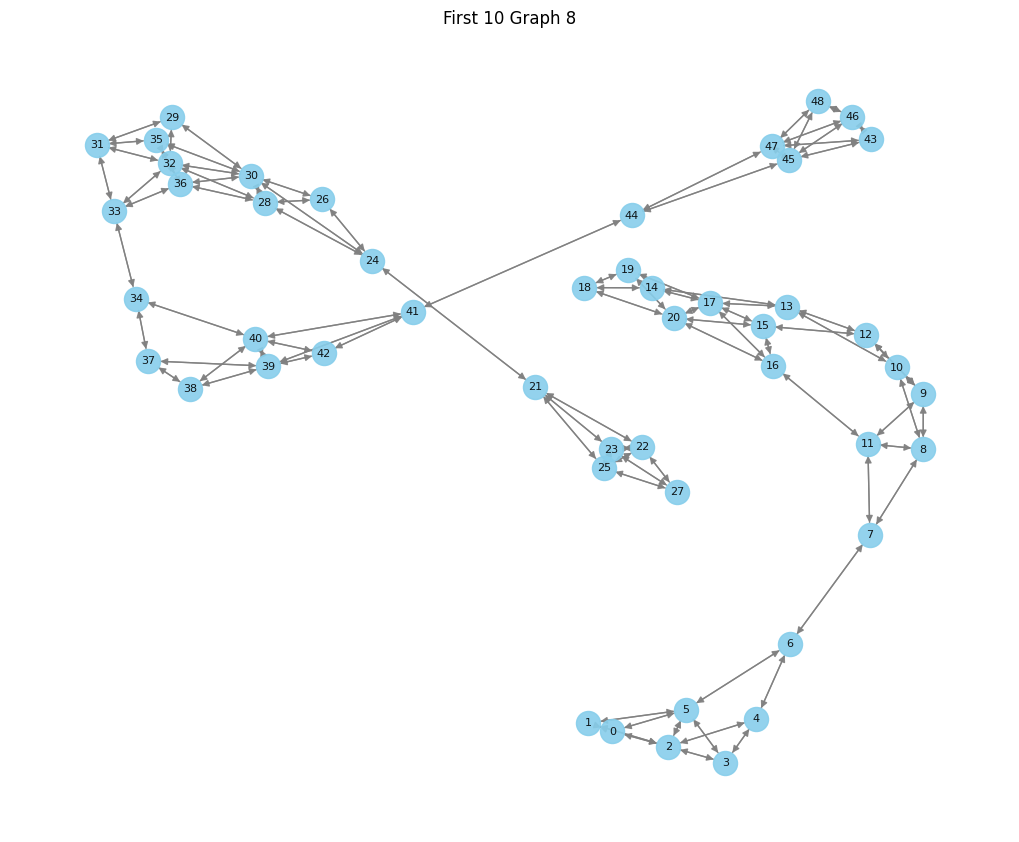

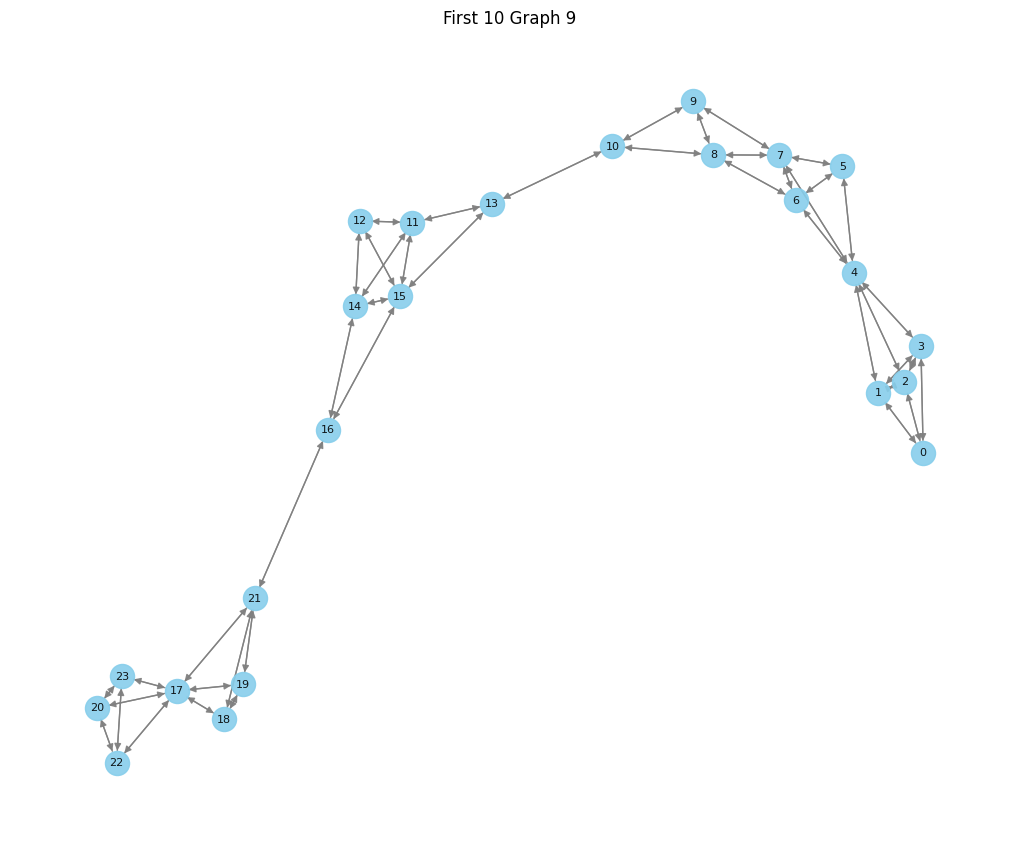

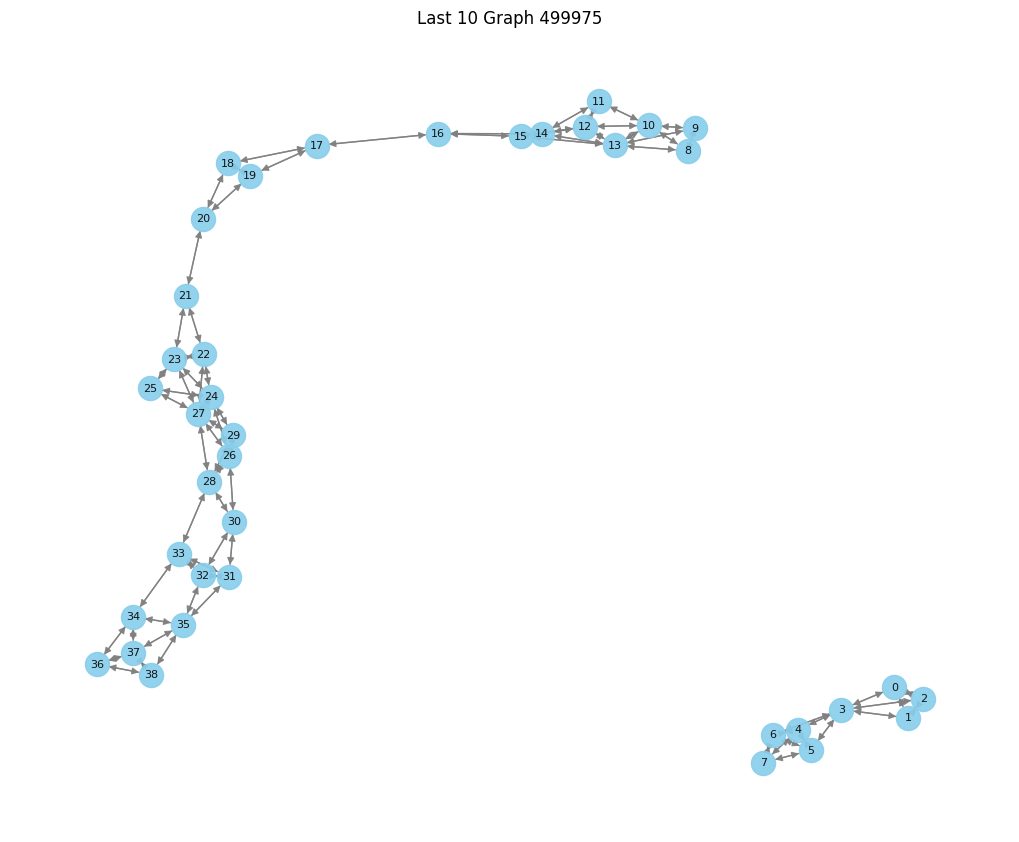

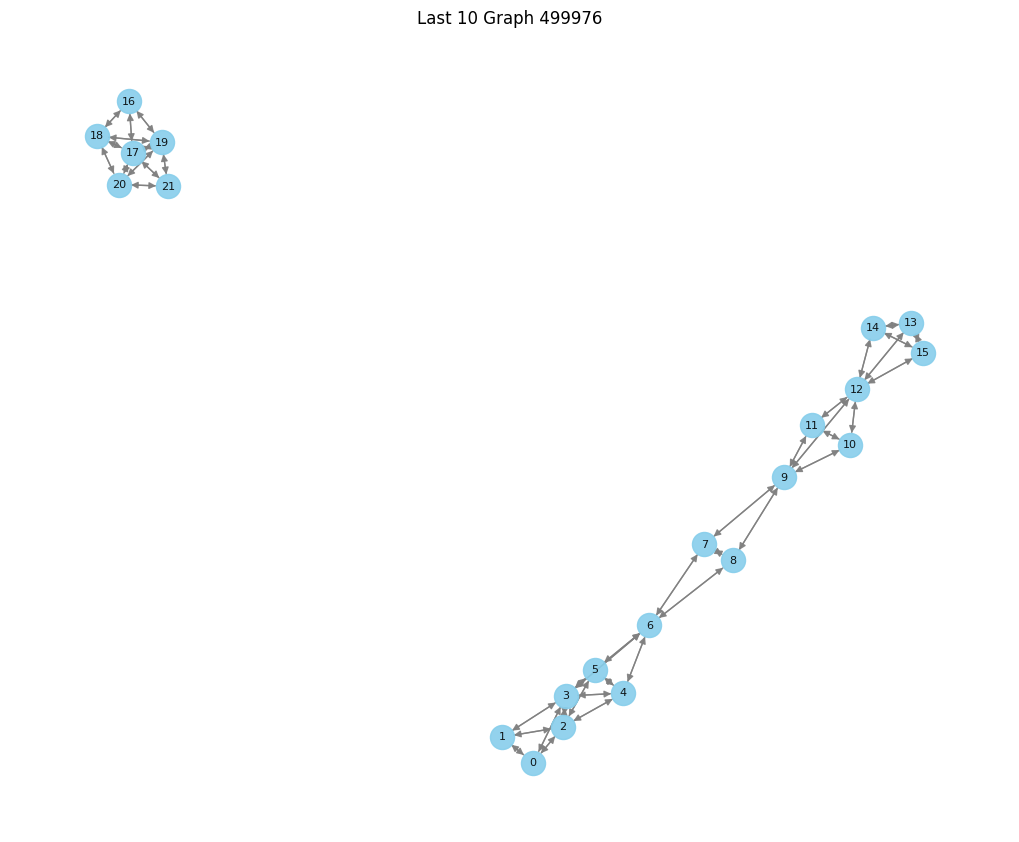

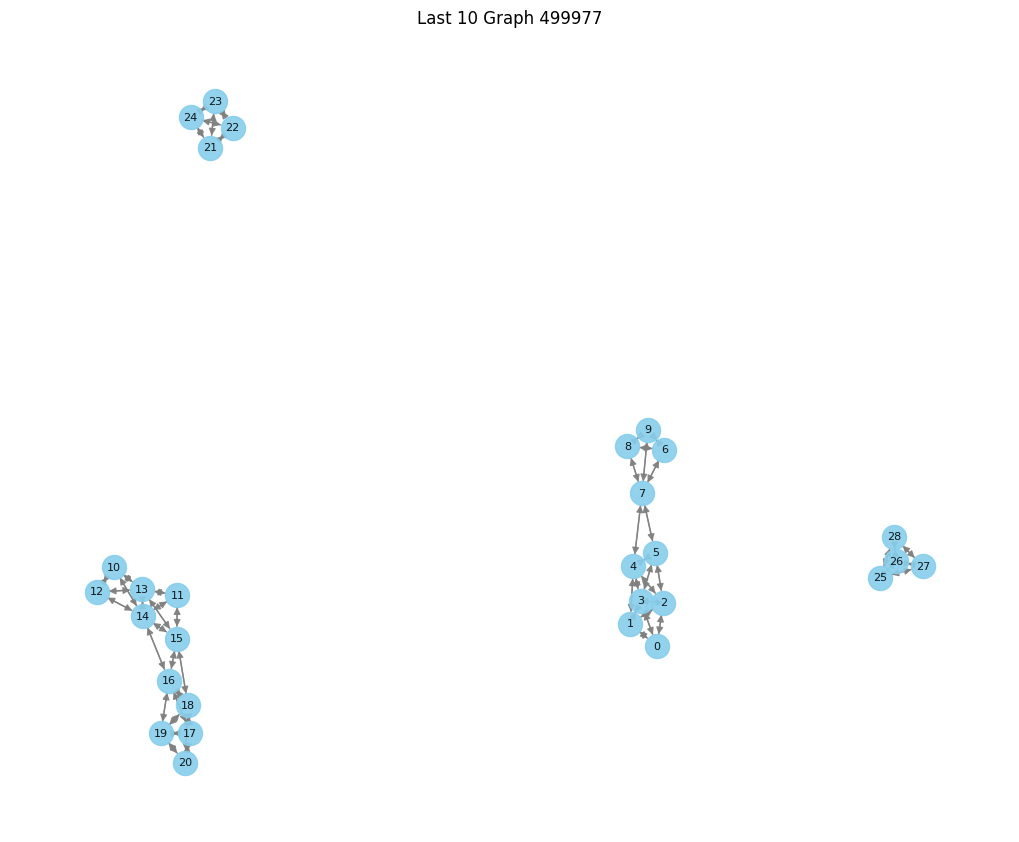

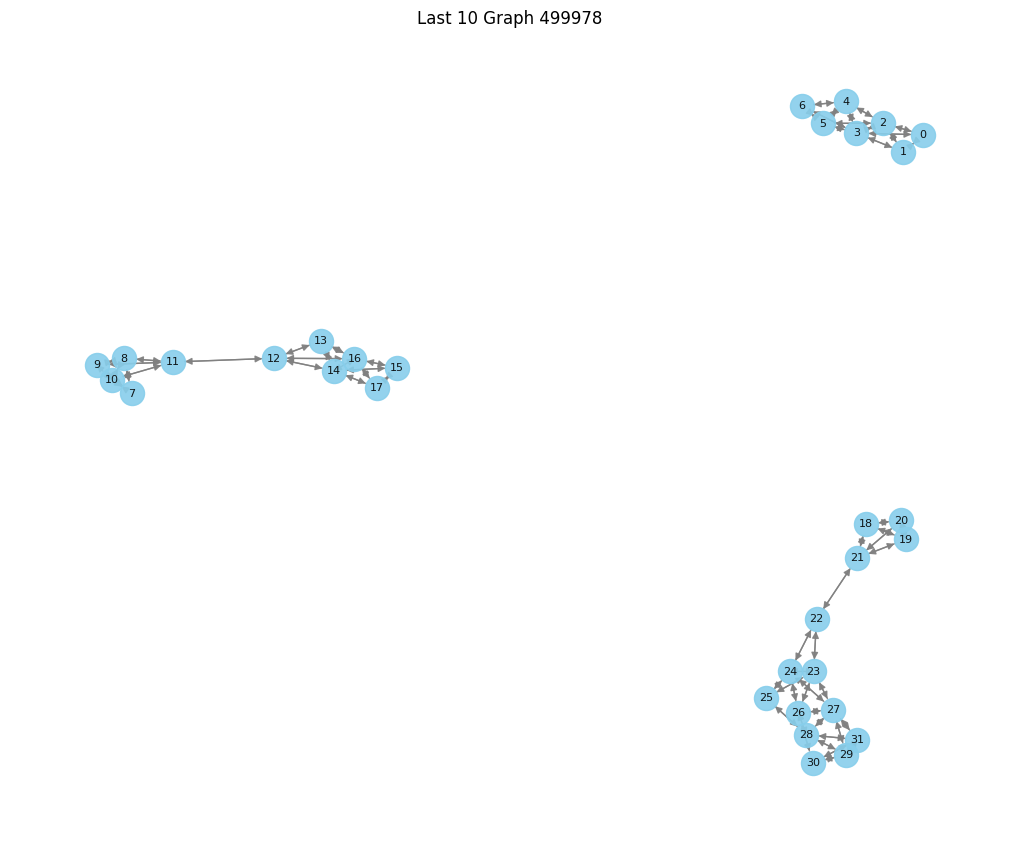

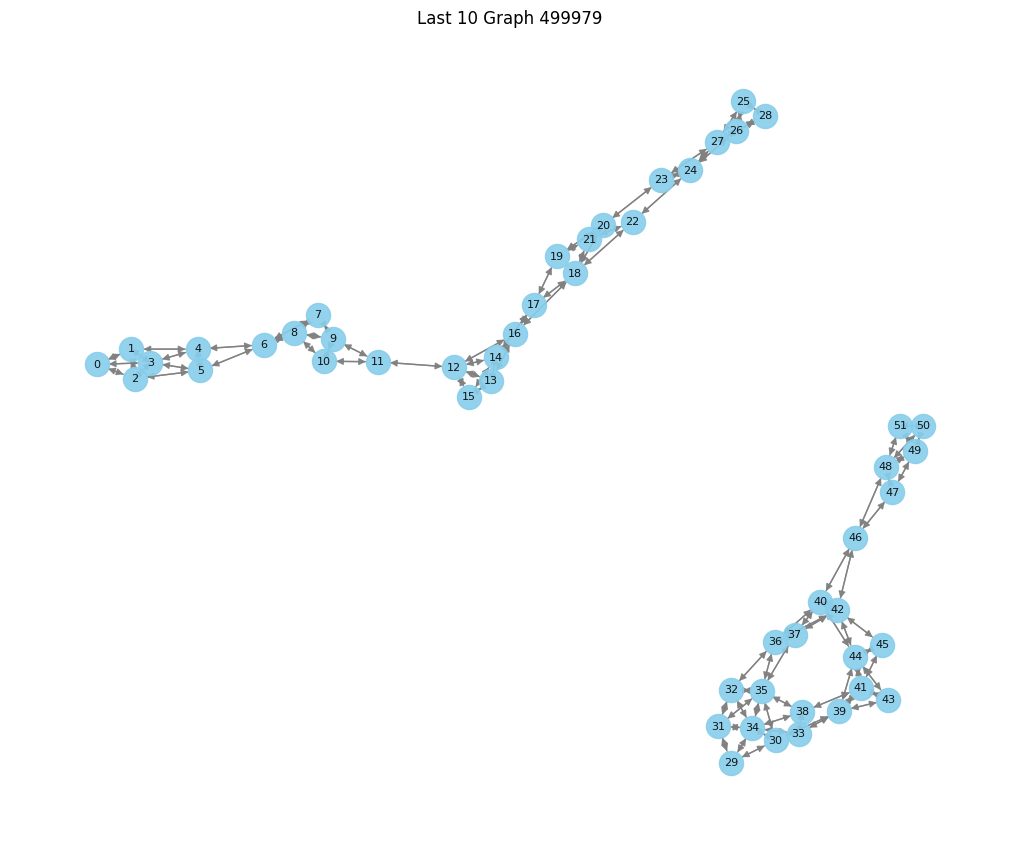

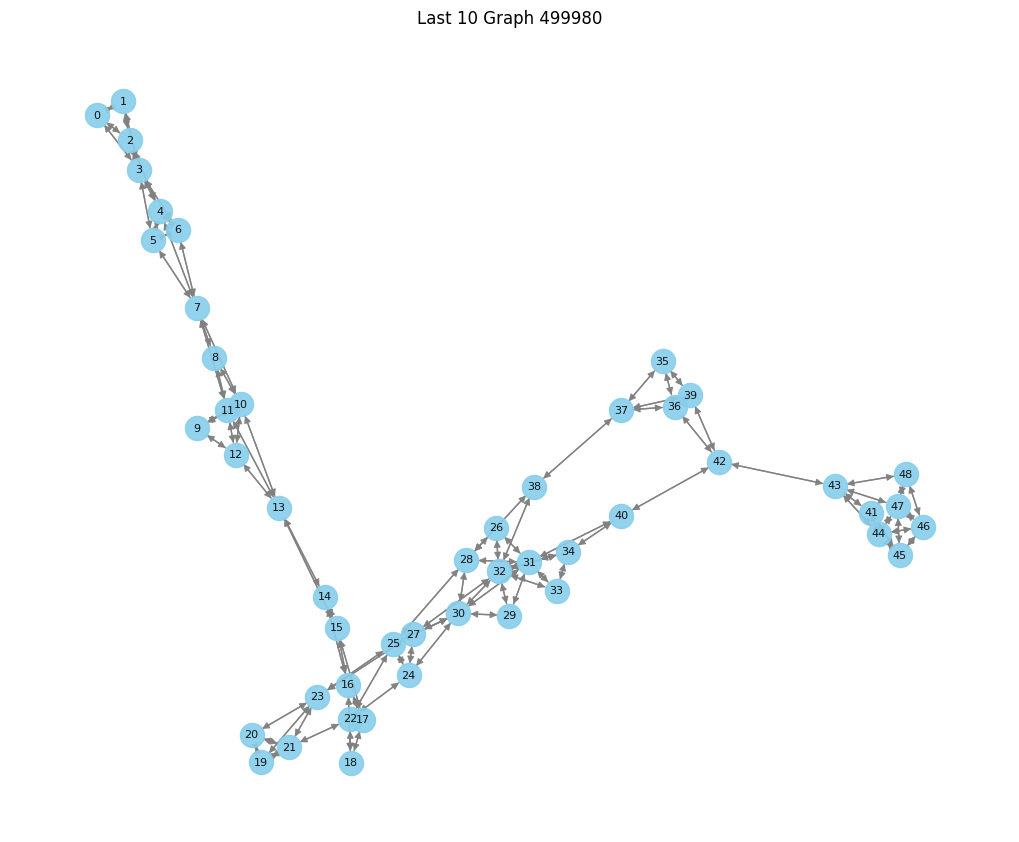

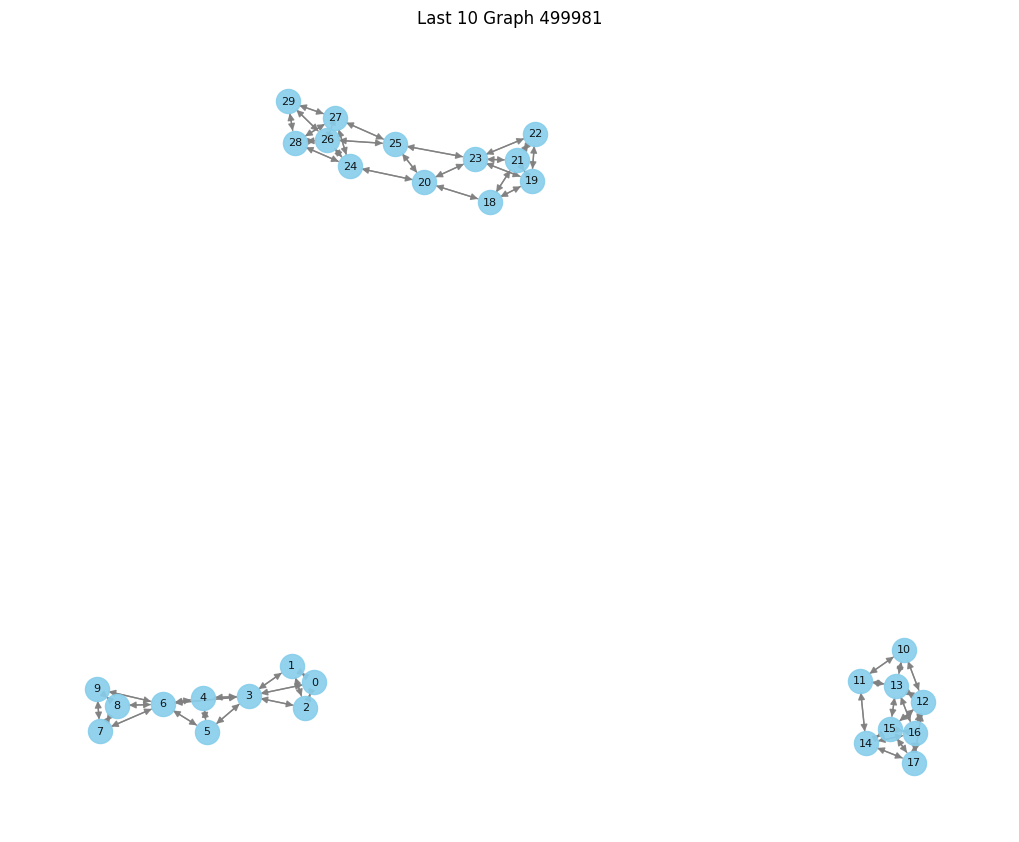

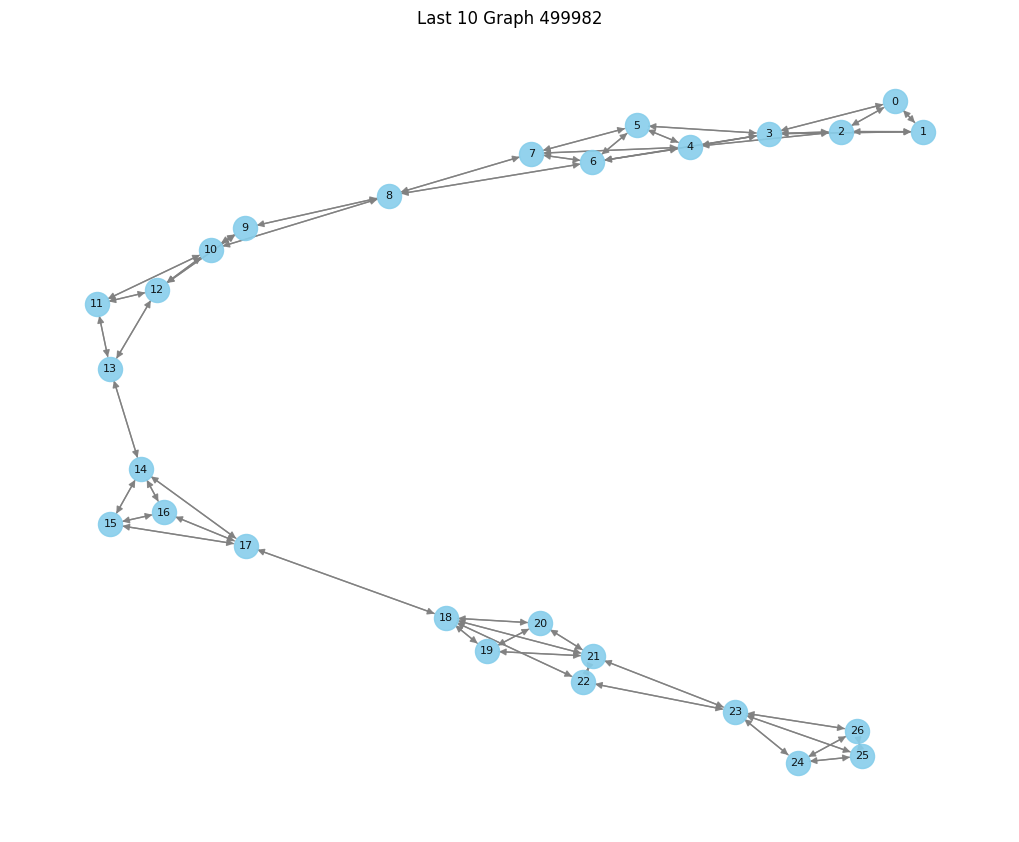

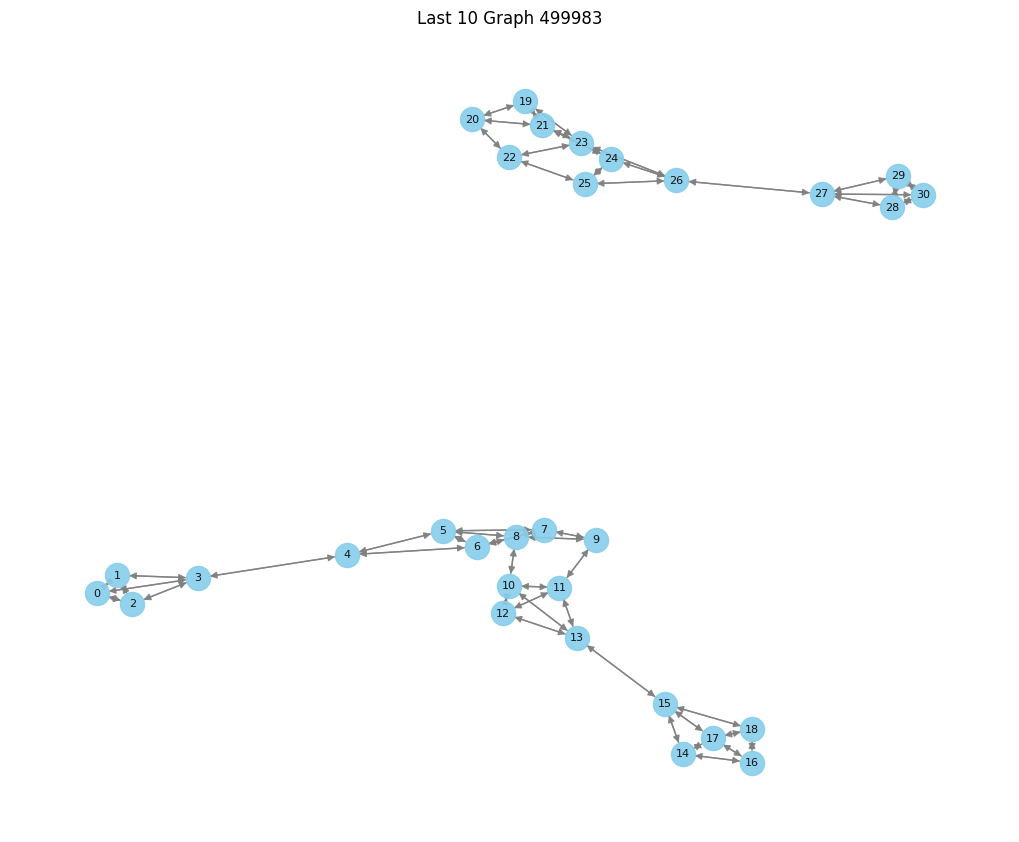

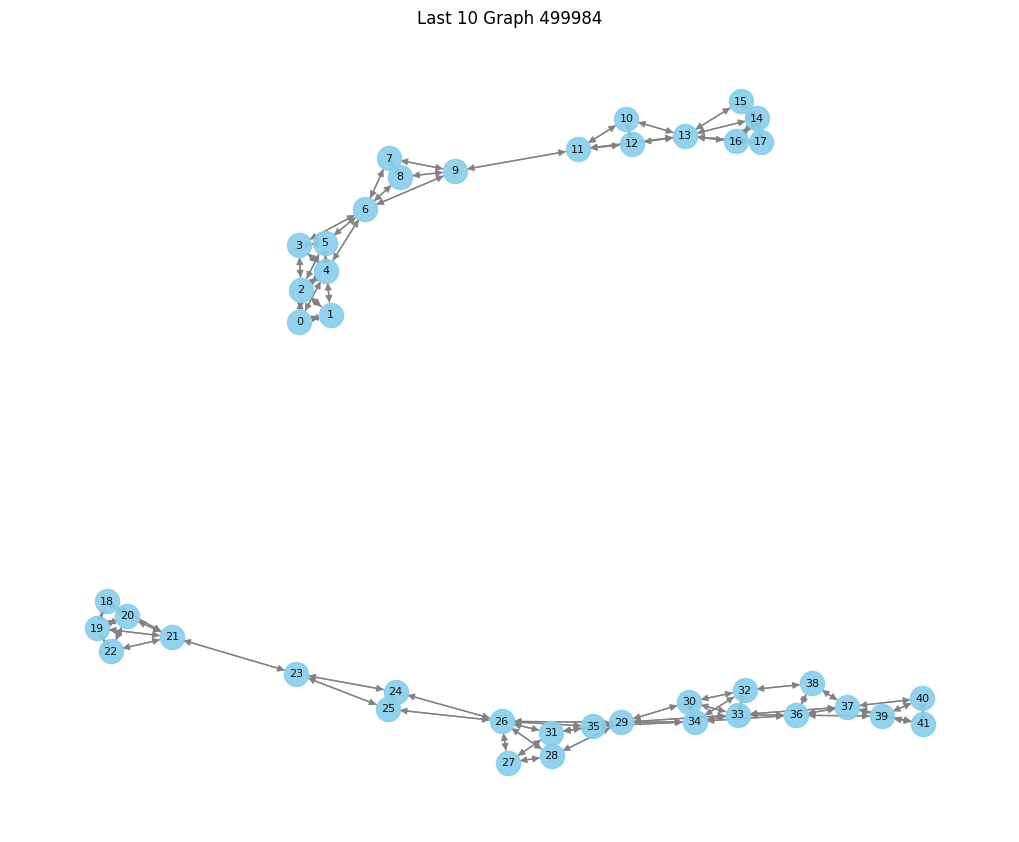

In [ ]:
# Load the saved .pkl file
file_path = './data/Multi Level Jet Tagging/Emitter-Higgs.pkl'
try:
    with open(file_path, 'rb') as f:
        graphs = pickle.load(f)
    print(f"File loaded successfully! Total number of graphs: {len(graphs)}")
except Exception as e:
    print(f"Failed to load the file: {e}")

# Function to visualize a graph with node labels
def visualize_graph_with_labels(graphs, indices, title_prefix):
    for idx in indices:
        g = graphs[idx]
        nx_graph = g.to_networkx()

        # Layout for better graph organization
        pos = nx.spring_layout(nx_graph)

        plt.figure(figsize=(10, 8))
        nx.draw(
            nx_graph, pos,
            with_labels=True,
            labels={node: node for node in nx_graph.nodes()},
            node_size=300,
            node_color="skyblue",
            font_size=8,
            font_color="black",
            edge_color="gray",
            alpha=0.9
        )
        plt.title(f"{title_prefix} Graph {idx}")
        plt.show()

# Visualize the first and last 10 graphs with node labels
first_10_indices = list(range(min(10, len(graphs))))
last_10_indices = list(range(max(0, len(graphs) - 10), len(graphs)))

visualize_graph_with_labels(graphs, first_10_indices, "First 10")
visualize_graph_with_labels(graphs, last_10_indices, "Last 10")
